In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset and Preprocessing

dataset1 = "/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/diabetes_binary_health_indicators_BRFSS2015.csv"
dataset2 = "/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/diabetes.csv"

In [ ]:
import pandas as pd

file_path1 = "/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/diabetes_binary_health_indicators_BRFSS2015.csv"
file_path2 = "/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/diabetes.csv"

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

In [ ]:
df1.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
print(df1['Diabetes_binary'].value_counts())

Diabetes_binary
0.0    218334
1.0     35346
Name: count, dtype: int64


In [ ]:
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
print(df2['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [ ]:
# drop duplicates
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

### dataset1 SMOTE

- for dataset 1
  - 0 : 218334
  - 1 : 35346

- Using SMOTENC here
  - generates new examples of the minority class using nearest neighbors of these cases, and can handle categorical variables;


In [ ]:
print(df1.nunique())

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

X1 = df1.drop(columns=['Diabetes_binary'])
y1 = df1['Diabetes_binary']

# binary or ordinal
binary_features = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
    'DiffWalk', 'Sex'
]
ordinal_features = ['GenHlth', 'Education', 'Income', 'Age', 'MentHlth', 'PhysHlth']
categorical_features = [col for col in (binary_features + ordinal_features) if col in X1.columns]
categorical_indices = [X1.columns.get_loc(col) for col in categorical_features]

# split trainging and testing
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=42, stratify=y1
)

# use SMOTENC just for training set
smote_nc = SMOTENC(
    categorical_features=categorical_indices,
    sampling_strategy='auto',
    random_state=42
)
X1_train_smote, y1_train_smote = smote_nc.fit_resample(X1_train, y1_train)

print("Before SMOTENC on ds1 training set：\n", y1_train.value_counts())
print("After SMOTENC on ds1 training set：\n", y1_train_smote.value_counts())

Before SMOTENC on ds1 training set：
 Diabetes_binary
0.0    174667
1.0     28277
Name: count, dtype: int64
After SMOTENC on ds1 training set：
 Diabetes_binary
0.0    174667
1.0    174667
Name: count, dtype: int64


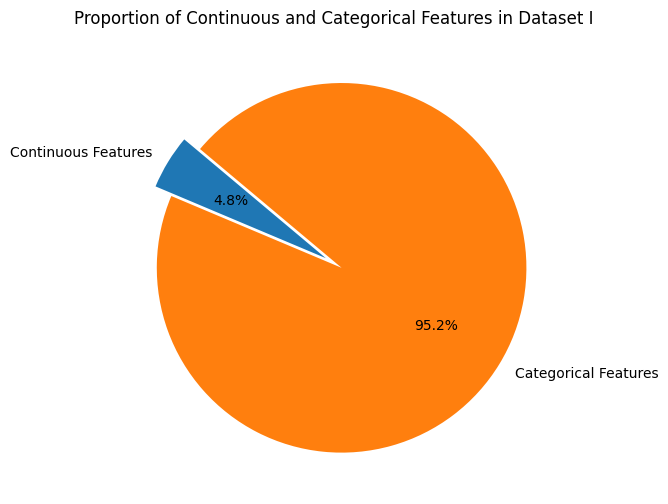

In [ ]:
import matplotlib.pyplot as plt

# 获取所有特征
all_features = list(X1.columns)
# 种类型特征已知
cat_features = categorical_features
# 连续性特征是剩下的部分
cont_features = [col for col in all_features if col not in cat_features]

sizes = [len(cont_features), len(cat_features)]
labels = ['Continuous Features', 'Categorical Features']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0.05, 0.05))
plt.title('Proportion of Continuous and Categorical Features in Dataset I')
plt.show()


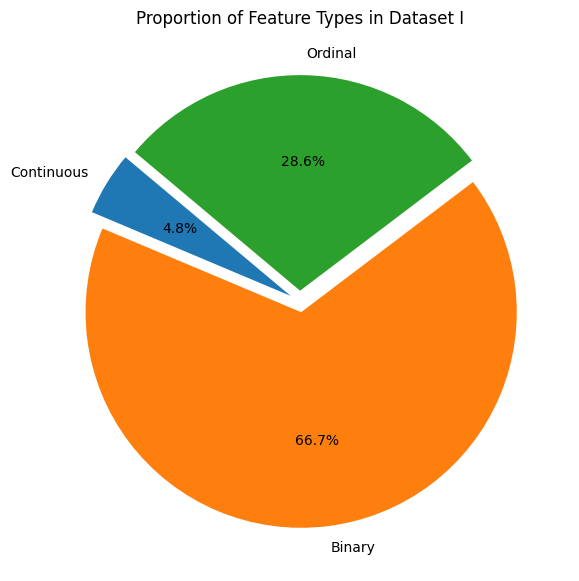

In [ ]:
sizes = [len([col for col in all_features if col not in binary_features + ordinal_features]),
         len(binary_features),
         len(ordinal_features)]
labels = ['Continuous', 'Binary', 'Ordinal']

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=(0.05, 0.05, 0.05))
plt.title('Proportion of Feature Types in Dataset I')
plt.show()

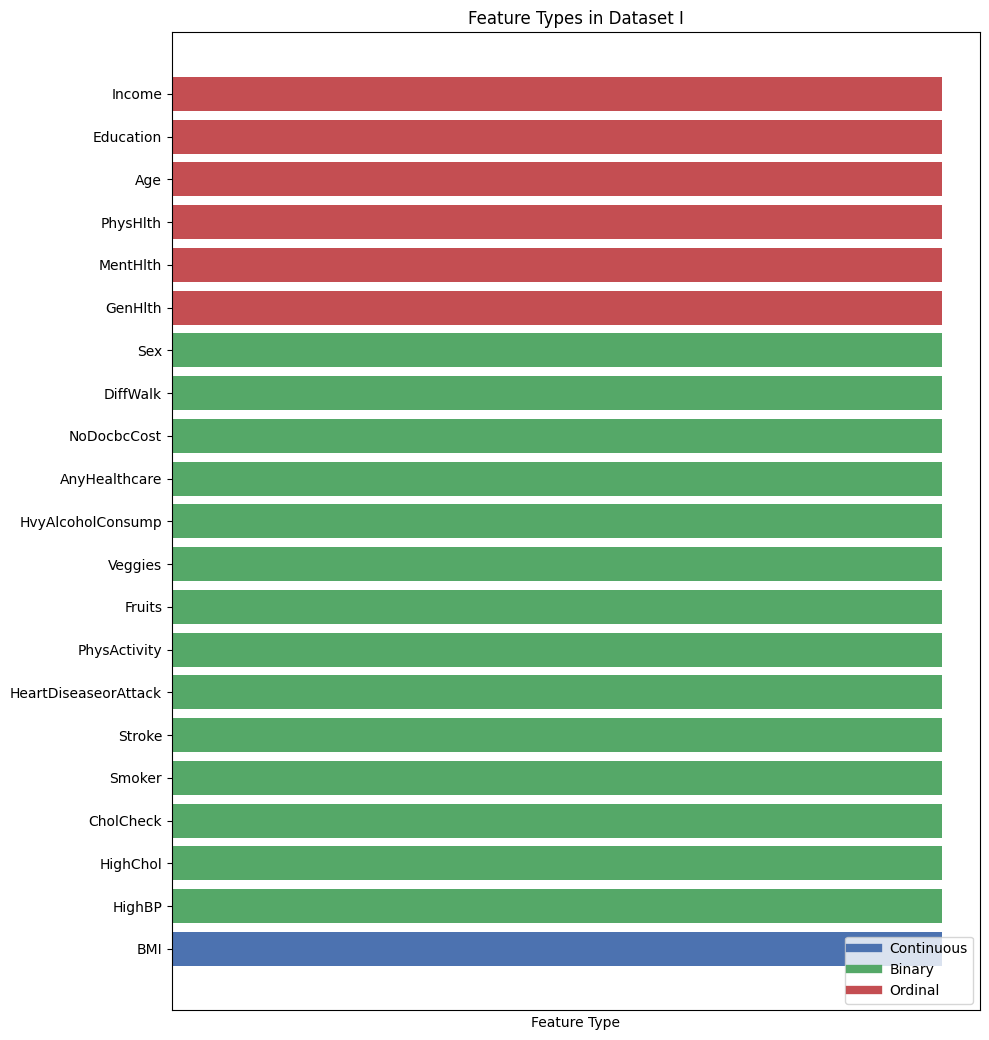

In [ ]:
import matplotlib.pyplot as plt

# 分类
cont_features = [col for col in X1.columns if col not in binary_features + ordinal_features]
bin_features = [col for col in X1.columns if col in binary_features]
ord_features = [col for col in X1.columns if col in ordinal_features]

feature_types = (
    [(f, 'Continuous') for f in cont_features] +
    [(f, 'Binary') for f in bin_features] +
    [(f, 'Ordinal') for f in ord_features]
)
# 保证顺序
feature_types = sorted(feature_types, key=lambda x: ['Continuous', 'Binary', 'Ordinal'].index(x[1]))

# 拆分绘制
features, types = zip(*feature_types)
colors = {'Continuous': '#4C72B0', 'Binary': '#55A868', 'Ordinal': '#C44E52'}
bar_colors = [colors[t] for t in types]

plt.figure(figsize=(10, len(features) * 0.5))
plt.barh(features, [1]*len(features), color=bar_colors)
plt.yticks(fontsize=10)
plt.xticks([])
plt.xlabel("Feature Type")
legend_patches = [plt.Line2D([0], [0], color=color, lw=6) for color in colors.values()]
plt.legend(legend_patches, colors.keys(), loc='lower right')
plt.title("Feature Types in Dataset I")
plt.tight_layout()
plt.show()


### dataset2 SMOTE

In [ ]:
print(df2.nunique())

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X2 = df2.drop(columns=['Outcome'])
y2 = df2['Outcome']

# split training and testing
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

# use SMOTE just on training set
smote = SMOTE(random_state=42)
X2_train_smote, y2_train_smote = smote.fit_resample(X2_train, y2_train)

print("Before SMOTE on ds2 training set：\n", y2_train.value_counts())
print("After SMOTE on ds2 training set：\n", y2_train_smote.value_counts())

Before SMOTE on ds2 training set：
 Outcome
0    400
1    214
Name: count, dtype: int64
After SMOTE on ds2 training set：
 Outcome
0    400
1    400
Name: count, dtype: int64


## Model traning



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# dataset 1
X_train_tensor1 = torch.tensor(X1_train_smote.values, dtype=torch.float32)
y_train_tensor1 = torch.tensor(y1_train_smote.values, dtype=torch.float32).view(-1, 1)
X_test_tensor1  = torch.tensor(X1_test.values, dtype=torch.float32)
y_test_tensor1  = torch.tensor(y1_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
print(X1.shape[1])

21


In [ ]:
# dataset 2
X_train_tensor2 = torch.tensor(X2_train_smote.values, dtype=torch.float32)
y_train_tensor2 = torch.tensor(y2_train_smote.values, dtype=torch.float32).view(-1, 1)
X_test_tensor2  = torch.tensor(X2_test.values, dtype=torch.float32)
y_test_tensor2  = torch.tensor(y2_test.values, dtype=torch.float32).view(-1, 1)

In [ ]:
print(X2.shape[1])

8


In [ ]:
# model definition

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

class NineLayerMLP(nn.Module):
    def __init__(self, input_dim):
        super(NineLayerMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.1),

            # output layer
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

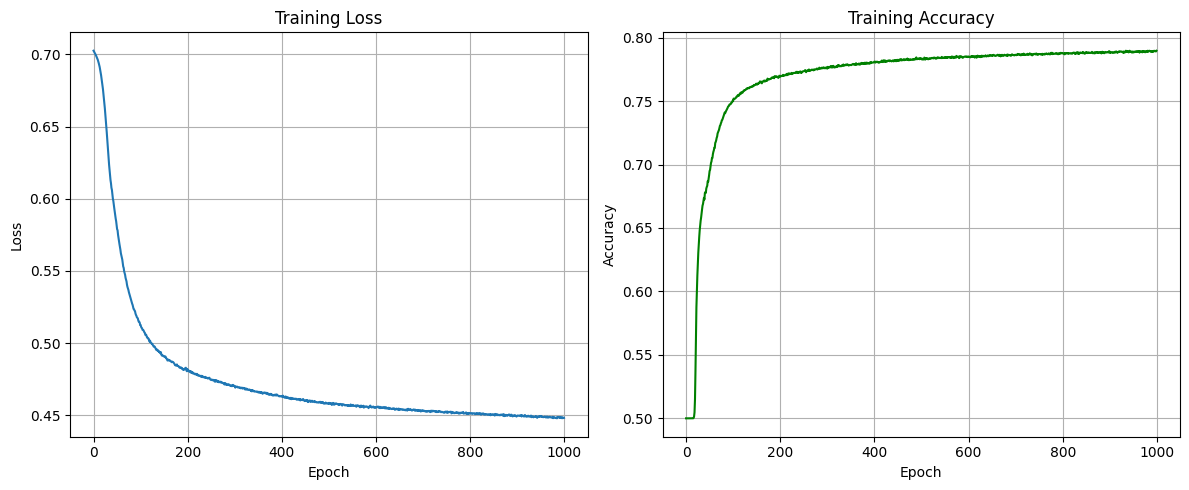

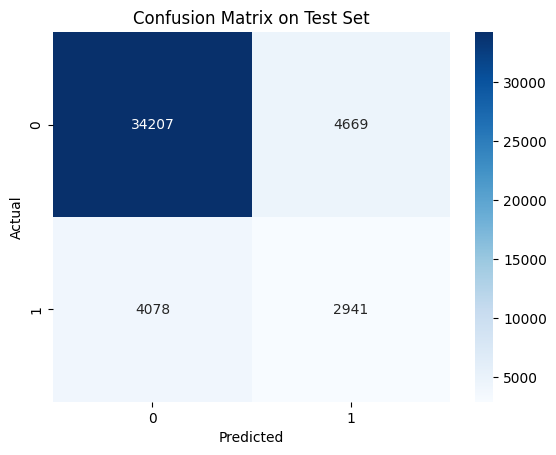

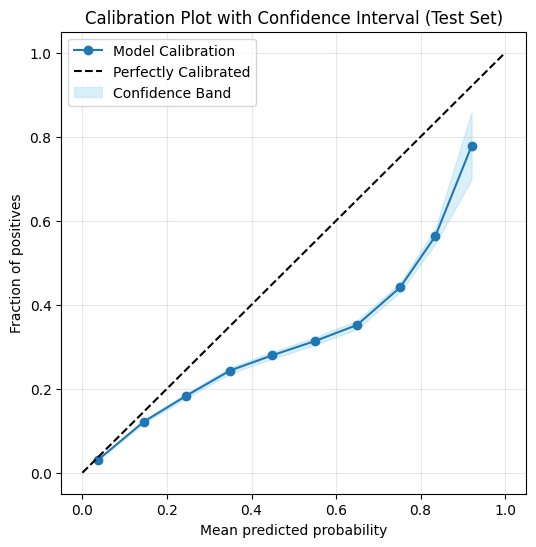

In [ ]:
# dataset1

X_train_tensor1 = X_train_tensor1.to(device)
y_train_tensor1 = y_train_tensor1.to(device)
X_test_tensor1 = X_test_tensor1.to(device)
y_test_tensor1 = y_test_tensor1.to(device)

model1 = NineLayerMLP(input_dim=X1.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

epochs = 1000
train_loss_list = []
train_acc_list = []

for epoch in range(epochs):
    model1.train()
    outputs = model1(X_train_tensor1)
    loss = criterion(outputs, y_train_tensor1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    preds_class = (outputs > 0.5).float()
    acc = accuracy_score(y_train_tensor1.cpu().numpy(), preds_class.detach().cpu().numpy())
    train_loss_list.append(loss.item())
    train_acc_list.append(acc)

    # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

torch.save(model1.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/model1_smotetraining.pth')

# loss and acc curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
# ====== Confusion Matrix ======
model1.eval()
with torch.no_grad():
    test_preds = model1(X_test_tensor1)
    test_preds_class = (test_preds > 0.5).float()

    cm = confusion_matrix(y_test_tensor1.cpu().numpy(), test_preds_class.cpu().numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix on Test Set')
    plt.show()

    # ==== Calibration Plot with Confidence Interval ====
    import numpy as np
    from sklearn.calibration import calibration_curve

    y_true = y_test_tensor1.cpu().numpy().flatten()
    y_prob = test_preds.cpu().numpy().flatten()

    n_bins = 10
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    binids[binids == n_bins] = n_bins - 1

    ci = []
    for i in range(n_bins):
        mask = binids == i
        n = np.sum(mask)
        if n > 0:
            p = np.mean(y_true[mask])
            se = np.sqrt(p * (1 - p) / n)
            ci.append(se)
        else:
            ci.append(0)
    ci = np.array(ci)

    plt.figure(figsize=(6, 6))
    plt.plot(mean_pred, frac_pos, "o-", label="Model Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    plt.fill_between(mean_pred,
                     frac_pos - ci, frac_pos + ci,
                     color='skyblue', alpha=0.3, label="Confidence Band")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot with Confidence Interval (Test Set)")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.grid(alpha=0.3)
    plt.show()

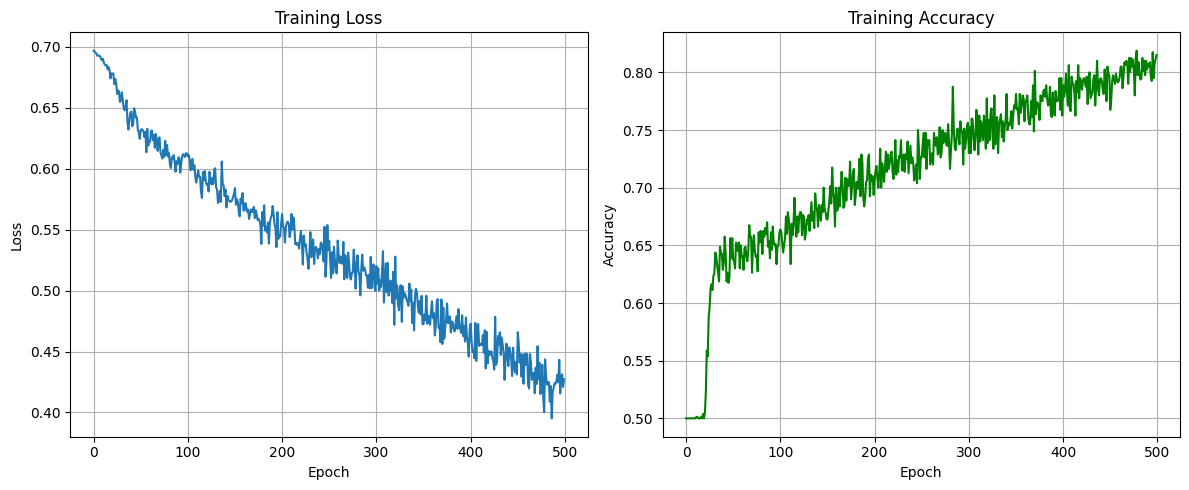

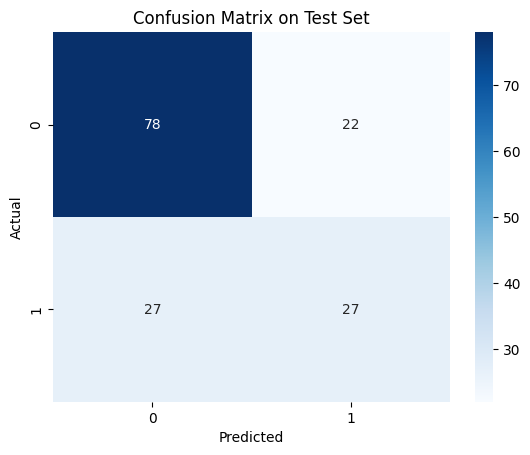

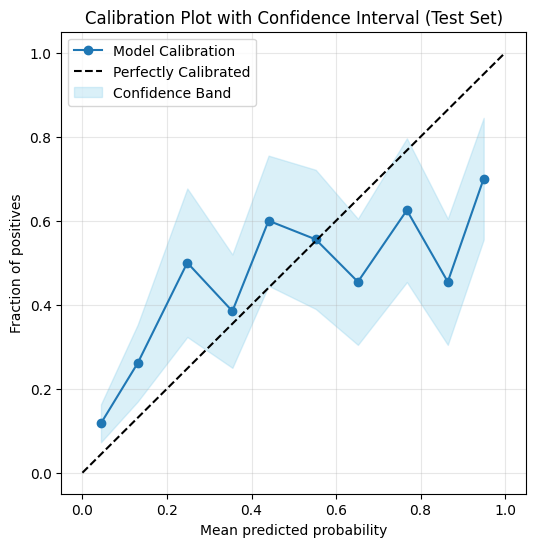

In [ ]:
# dataset2

X_train_tensor2 = X_train_tensor2.to(device)
y_train_tensor2 = y_train_tensor2.to(device)
X_test_tensor2 = X_test_tensor2.to(device)
y_test_tensor2 = y_test_tensor2.to(device)

model2 = NineLayerMLP(input_dim=X2.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

epochs = 500
train_loss_list = []
train_acc_list = []

for epoch in range(epochs):
    model2.train()
    outputs = model2(X_train_tensor2)
    loss = criterion(outputs, y_train_tensor2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    preds_class = (outputs > 0.5).float()
    acc = accuracy_score(y_train_tensor2.cpu().numpy(), preds_class.detach().cpu().numpy())
    train_loss_list.append(loss.item())
    train_acc_list.append(acc)

    # print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

# save model
torch.save(model2.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Proximity counterfactual paper/model2_smotetraining.pth')

# loss and acc curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
model2.eval()
with torch.no_grad():
    test_preds = model2(X_test_tensor2)
    test_preds_class = (test_preds > 0.5).float()

    cm = confusion_matrix(y_test_tensor2.cpu().numpy(), test_preds_class.cpu().numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix on Test Set')
    plt.show()

    # ==== Calibration Plot with Confidence Interval ====
    import numpy as np
    from sklearn.calibration import calibration_curve

    y_true = y_test_tensor2.cpu().numpy().flatten()
    y_prob = test_preds.cpu().numpy().flatten()

    n_bins = 10
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    binids[binids == n_bins] = n_bins - 1

    ci = []
    for i in range(n_bins):
        mask = binids == i
        n = np.sum(mask)
        if n > 0:
            p = np.mean(y_true[mask])
            se = np.sqrt(p * (1 - p) / n)
            ci.append(se)
        else:
            ci.append(0)
    ci = np.array(ci)

    plt.figure(figsize=(6, 6))
    plt.plot(mean_pred, frac_pos, "o-", label="Model Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
    plt.fill_between(mean_pred,
                     frac_pos - ci, frac_pos + ci,
                     color='skyblue', alpha=0.3, label="Confidence Band")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot with Confidence Interval (Test Set)")
    plt.legend()
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.grid(alpha=0.3)
    plt.show()